# Bollinger bands


In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from utils import get_data, get_return_simulation
from strategies import bollinger_bands

plt.style.use("seaborn")

In [2]:
weights = [0.5, 0.4, 0.023, 0.033, 0.043]

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

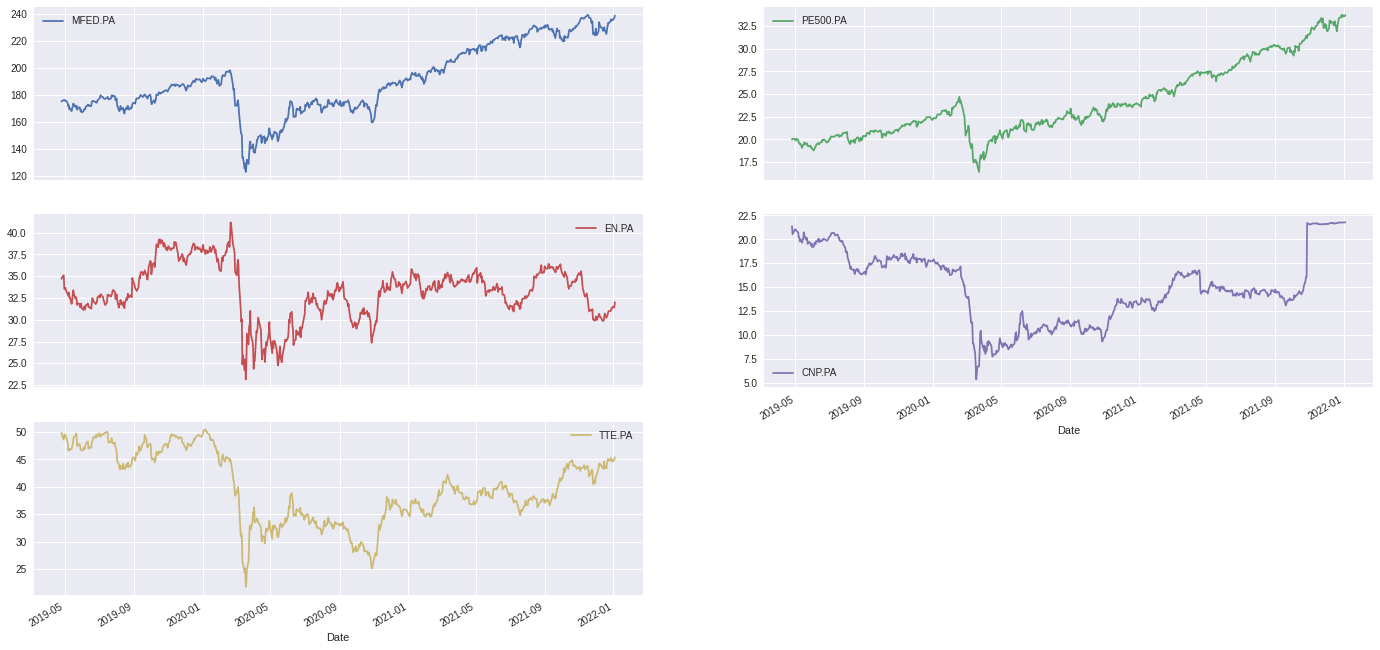

In [3]:
df, stocks = get_data('stocks', columns=["Close", "High", "Low"])
df = df.dropna()

df['Close'].plot(figsize=(24, 12), subplots=True, layout=(3, 2))

In [4]:
tp = (df['Close'] + df['Low'] + df['High']) / 3
std = tp.rolling(20).std(ddof=0)
ma = tp.rolling(20).mean()
bolu = ma + 2 * std
bold = ma - 2 * std

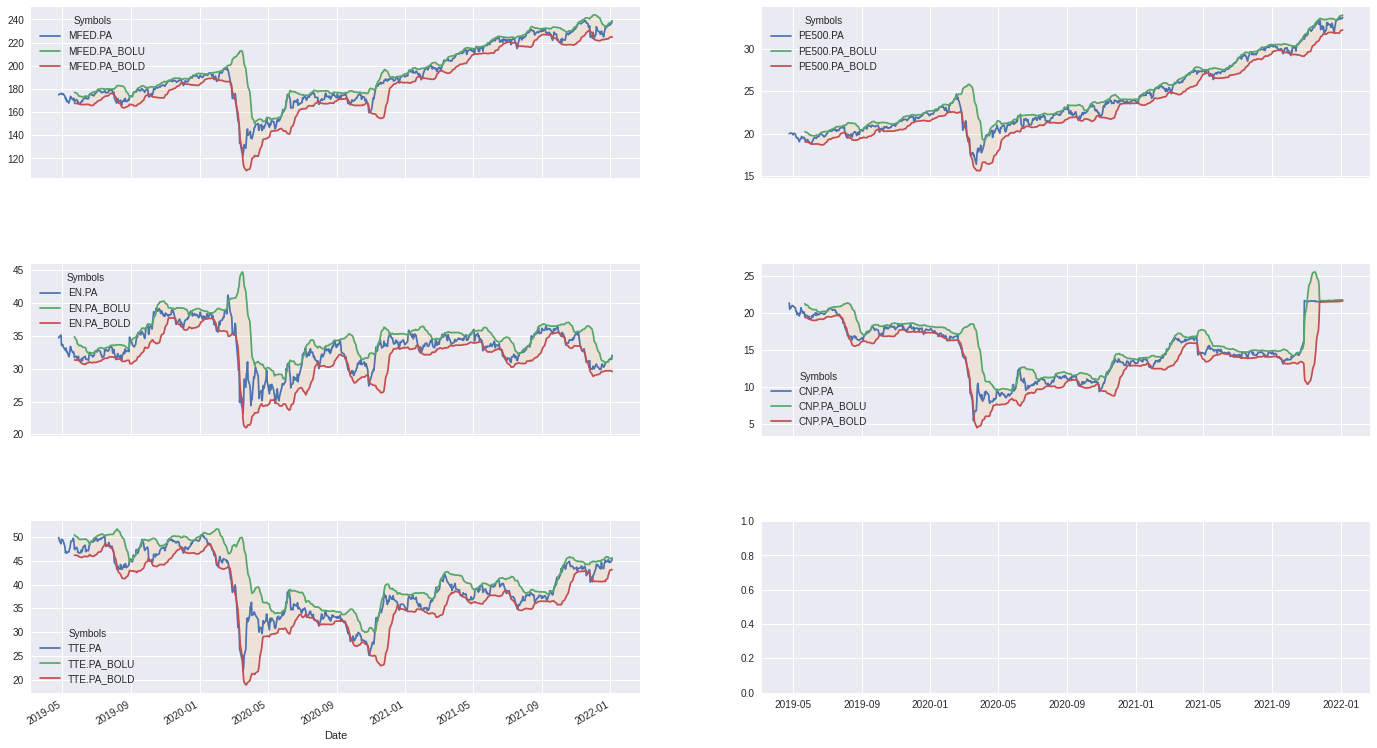

In [5]:
bollinger = pd.concat([
    df['Close'],
    bolu.add_suffix('_BOLU'),
    bold.add_suffix('_BOLD')
], axis=1)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    ax = bollinger[[s, f"{s}_BOLU", f"{s}_BOLD"]].plot(
        figsize=(24, 14), ax=axes[i // 2, i % 2]
    )
    ax.fill_between(bollinger.index, bollinger[f"{s}_BOLD"], bollinger[f"{s}_BOLU"], facecolor='orange', alpha=0.1)

In [6]:
for s in stocks:
    bollinger[f"{s}_POSITION"] = np.where(
        bollinger[s] <= bollinger[f"{s}_BOLD"], 1, 0
    )
    bollinger[f"{s}_TRANSACTIONS"] = bollinger[f"{s}_POSITION"].diff().clip(lower=0)
    bollinger.loc[bollinger.index[0], f"{s}_TRANSACTIONS"] = 1

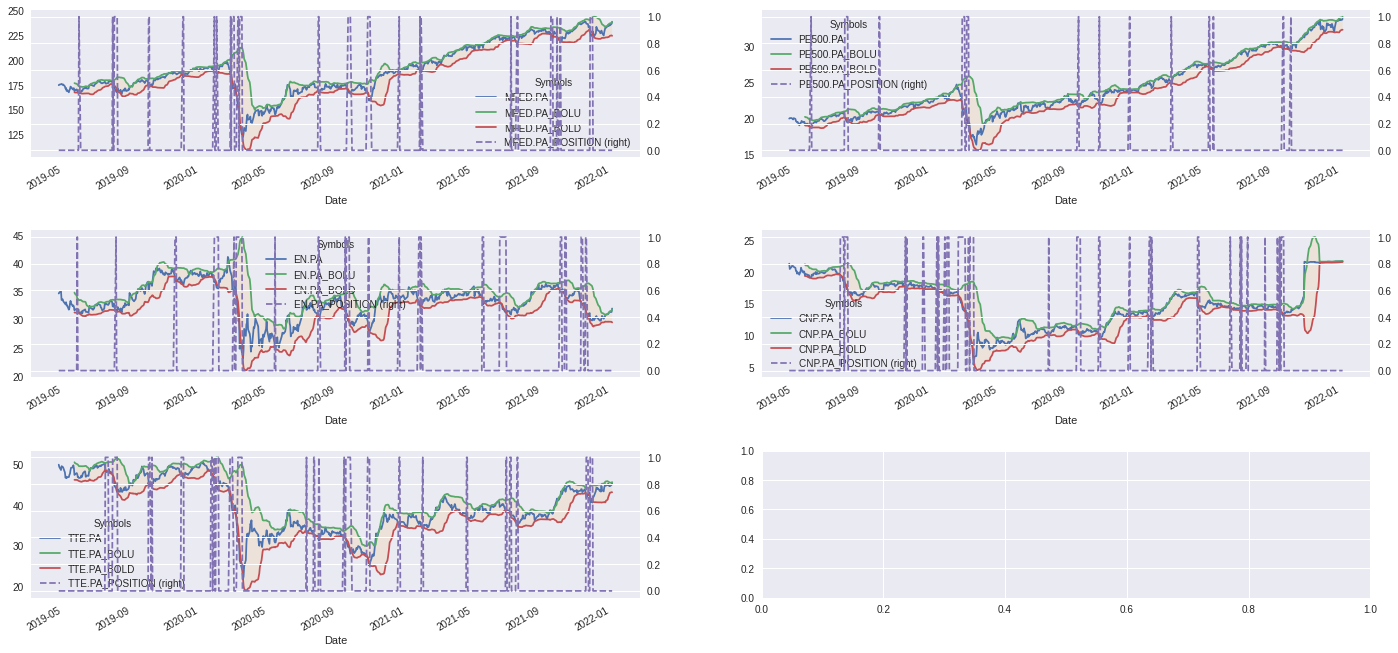

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    ax = bollinger[[s, f"{s}_BOLU", f"{s}_BOLD"]].plot(
        figsize=(24, 14), ax=axes[i // 2, i % 2]
    )
    ax.fill_between(bollinger.index, bollinger[f"{s}_BOLD"], bollinger[f"{s}_BOLU"], facecolor='orange', alpha=0.1)

    bollinger[[f"{s}_POSITION"]].plot(
            figsize=(24, 12), ax=ax, secondary_y=f"{s}_POSITION", style="--"
        )

In [8]:
get_return_simulation(bollinger, stocks)

{'MFED.PA': {'base returns': 1.3635583823033623,
  'amount invested': 4461.970001220703,
  'strategy returns': 1.283648220841617},
 'PE500.PA': {'base returns': 1.6872499465942383,
  'amount invested': 324.4069995880127,
  'strategy returns': 1.4562878903548908},
 'EN.PA': {'base returns': 0.9230546995695109,
  'amount invested': 686.040002822876,
  'strategy returns': 0.9804529934078736},
 'CNP.PA': {'base returns': 1.0177736708620906,
  'amount invested': 410.21499824523926,
  'strategy returns': 1.4852699414087347},
 'TTE.PA': {'base returns': 0.9091273427844775,
  'amount invested': 983.245002746582,
  'strategy returns': 1.153578172407407}}

In [11]:
symbols = stocks[:]
results = pd.DataFrame()


for periods in range(2, 30):
    current_df = bollinger_bands(df, symbols, periods=periods)

    return_simulation = get_return_simulation(current_df, symbols)
    market = sum(
        [w * return_simulation[s]["base returns"] for s, w in zip(symbols, weights)]
    )
    strategy = sum(
        [w * return_simulation[s]["strategy returns"] for s, w in zip(symbols, weights)]
    )

    results = results.append(
        pd.DataFrame(
            {
                "periods": periods,
                "market": market,
                "strategy": strategy,
                "out": strategy - market,
            },
            index=[0],
        ),
        ignore_index=True,
    )

results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   periods   28 non-null     int64  
 1   market    28 non-null     float64
 2   strategy  28 non-null     float64
 3   out       28 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.0 KB


In [12]:
results.sort_values("out", ascending=False).head(10)

,periods,market,strategy,out
18,20,1.450588,1.345507,-0.105081
19,21,1.450588,1.339907,-0.110682
20,22,1.450588,1.339718,-0.110871
15,17,1.450588,1.339646,-0.110942
9,11,1.450588,1.338741,-0.111848
17,19,1.450588,1.338177,-0.112411
16,18,1.450588,1.337470,-0.113118
10,12,1.450588,1.331263,-0.119326
3,5,1.450588,1.330224,-0.120365
1,3,1.450588,1.329487,-0.121101


## Conclusion

- 20 periods seems to fit the best
- the use of mean and standard deviation make the strategy a stable one